In [186]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns

from matplotlib import rcParams

sns.set_palette("husl")
sns.set_context("talk")
sns.set_palette(sns.color_palette("husl", 8)[5:])

sns.set_style("white", {"font.family": ['Courier New']})


In [187]:

import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, String
from sqlalchemy.ext.declarative import declarative_base, as_declarative
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine

@as_declarative()
class Base(object):
    def __repr__(self):
        return "<%s: %s>" % (self.__class__.__name__, self.__dict__)


# SQL definition that matches our table

class Articles(Base):
    __tablename__ = 'retractions' # rename this

    id = Column(Integer, primary_key=True)
    body = Column(String, nullable=False)
    title = Column(String, nullable=False)
    url = Column(String, nullable=False)
    event_id = Column(String, nullable=False)
    month = Column(String, nullable=False)
    year  = Column(String, nullable=False)
    correction_type = Column(Integer, nullable=True)
    correction_check = Column(Integer, nullable=True)
    correction_info = Column(String, nullable=True)


# Create a SQLAlchemy session

engine = create_engine('mysql://root@localhost/retractions')
Session = sessionmaker()
Session.configure(bind=engine)
sess = Session()


/Users/nbuxton/anaconda3/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py:1569: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


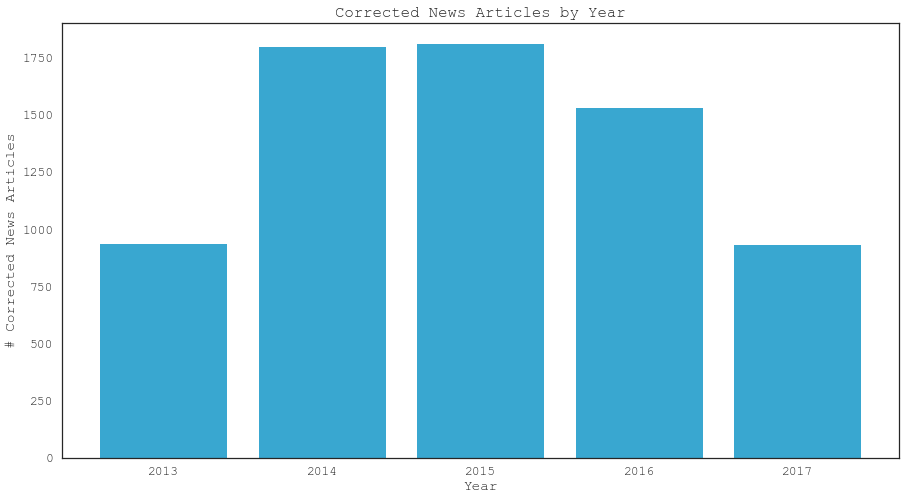

In [188]:
# 1/ Corrected news articles by year 
# 2/ Cumulative sum of corrected news articles by year
# 3/ Corrected new articles per 100k by year
# 4/ Corrected news articles by outlet
# 5/ Corrected news articles by outlet per 100k

years = []
counts = []
result = sess.execute('SELECT COUNT(*) as count, year FROM retractions WHERE correction_type!=0 GROUP BY year ORDER BY year DESC')
for r in result:
    counts.append(r[0])
    years.append(r[1])

# Initialize the matplotlib figure
ax = plt.subplots(figsize=(15, 8))

plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("# Corrected News Articles")
plt.title("Corrected News Articles by Year")
plt.show()

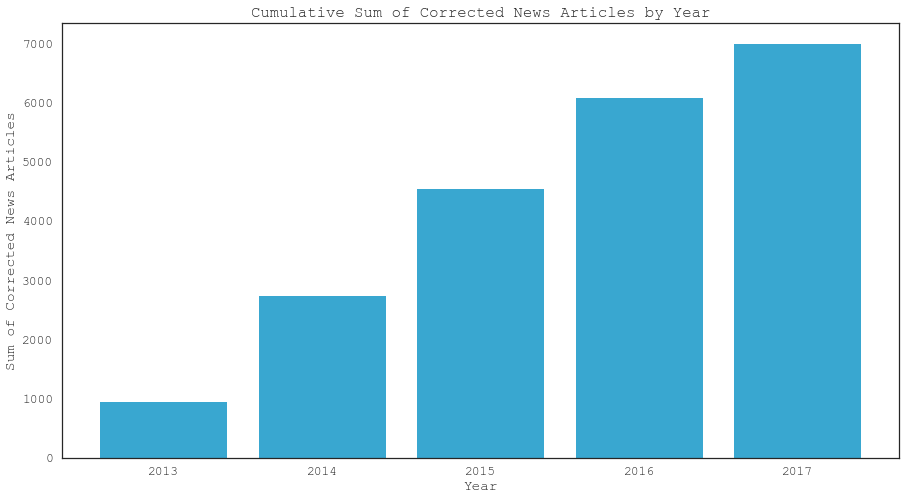

In [189]:
# cumulative
years = []
counts = []
acc = 0
result = sess.execute('SELECT COUNT(*) as count, year FROM retractions WHERE correction_type!=0 GROUP BY year ORDER BY year ASC')
for r in result:
    acc = acc+r[0]
    counts.append(acc)
    years.append(r[1])


#Initialize the matplotlib figure
ax = plt.subplots(figsize=(15, 8))

plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Sum of Corrected News Articles")
plt.title("Cumulative Sum of Corrected News Articles by Year")
plt.show()

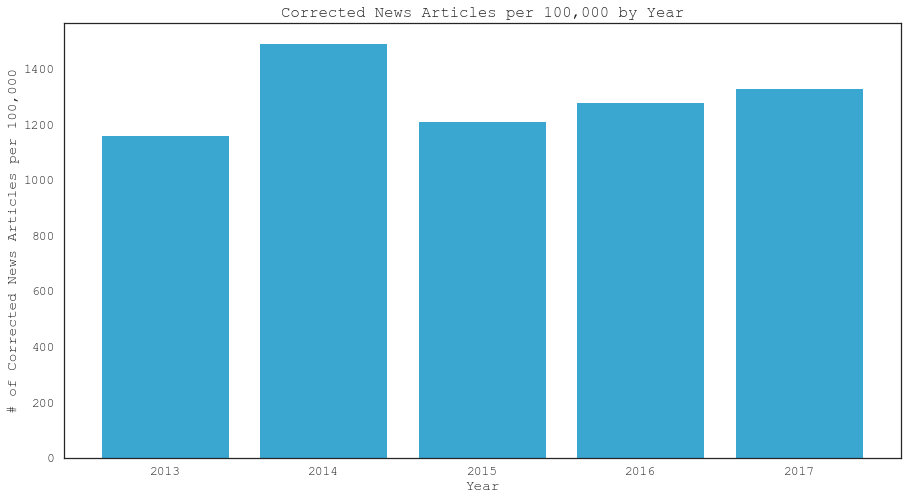

In [191]:
totals = {}
result = sess.execute('SELECT COUNT(*) as count, year FROM retractions GROUP BY year ORDER BY year DESC')
for r in result:
    totals[r[1]] = r[0]

years = []
counts = []
result = sess.execute('SELECT COUNT(*) as count, year FROM retractions WHERE correction_type!=0 GROUP BY year ORDER BY year DESC')
for r in result:
    year = r[1]
    total = totals[year]
#     print("%s Total %s - Corrections %s" % (year, total, r[0]))
    counts.append((r[0]/total)*100000)
    years.append(year)


#Initialize the matplotlib figure
ax = plt.subplots(figsize=(15, 8))


plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("# of Corrected News Articles per 100,000")
plt.title("Corrected News Articles per 100,000 by Year")
plt.show()

['breitbart.com', 'usatoday.com', 'cleveland.com', 'unionleader.com', 'wowktv.com', 'wboy.com', 'nj.com', 'bleedingheartland.com', 'cnn.com', 'theguardian.com', 'wrcbtv.com', 'nola.com', 'scpr.org', 'hlntv.com', 'af.reuters.com', 'in.reuters.com', 'oregonlive.com', 'texastribune.org', 'mlive.com', 'patch.com', 'wsaz.com', 'reuters.com', 'huffingtonpost.com', 'washingtonpost.com']
[45, 47, 47, 49, 51, 51, 52, 53, 56, 56, 62, 62, 63, 69, 75, 80, 83, 95, 98, 103, 112, 199, 232, 338]


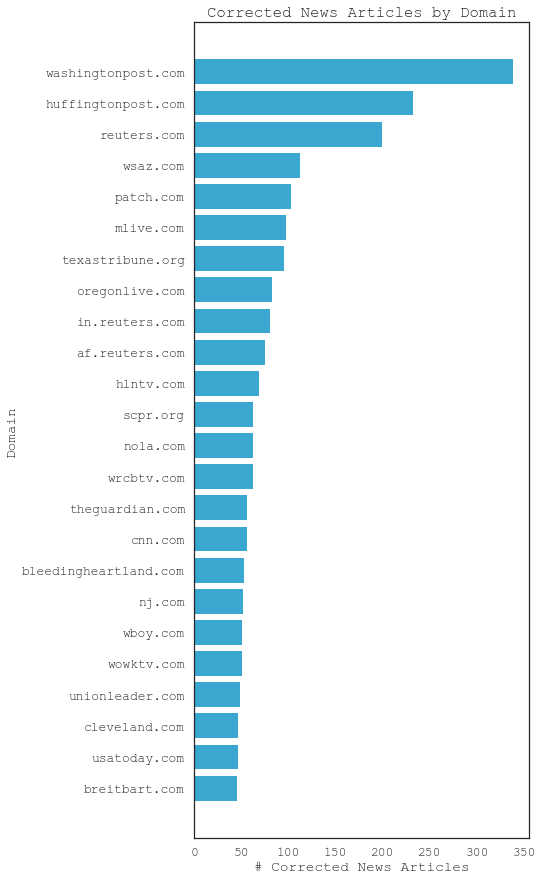

In [163]:
# 4/ Corrected news articles by outlet
# 5/ Corrected news articles by 

domains = []
counts = []
result = sess.execute('SELECT COUNT(*) as count, domain FROM retractions WHERE correction_type!=0 GROUP BY domain ORDER BY count DESC LIMIT 24')
for r in result:
    counts.append(r[0])
    domains.append(r[1])

ax = plt.subplots(figsize=(6, 15))

domains.reverse()
counts.reverse()

print(domains)
print(counts)
# plt.barh(domains, counts)
plt.barh(range(len(domains)),counts)
plt.yticks(range(len(domains)),domains)

plt.ylabel("Domain")
plt.xlabel("# of Corrected News Articles")
plt.title("Corrected News Articles by Domain")
plt.show()

('usatoday.com', 'unionleader.com', 'cleveland.com', 'breitbart.com', 'theguardian.com', 'nj.com', 'washingtonpost.com', 'mlive.com', 'patch.com', 'cnn.com', 'nola.com', 'oregonlive.com', 'huffingtonpost.com', 'reuters.com', 'in.reuters.com', 'scpr.org', 'wowktv.com', 'wrcbtv.com', 'wboy.com', 'texastribune.org', 'af.reuters.com', 'wsaz.com', 'bleedingheartland.com', 'hlntv.com')
(1071.3471620697514, 1285.414480587618, 1902.0639417239984, 2123.643227937707, 2377.91932059448, 2463.2875414495497, 2702.2705468500158, 3069.213905418102, 3891.1975821684923, 3894.2976356050067, 3987.138263665595, 4202.53164556962, 4453.829909771549, 9299.065420560748, 9987.515605493132, 16449.086161879895, 17465.753424657534, 17663.817663817663, 20158.10276679842, 21839.080459770117, 24115.755627009647, 30769.23076923077, 47747.74774774775, 84146.34146341463)


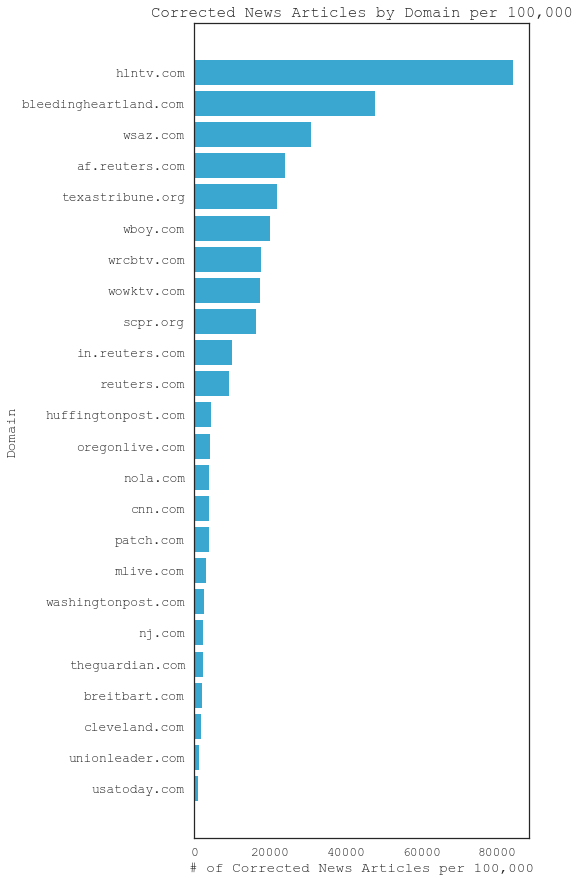

In [165]:
totals = {}
result = sess.execute('SELECT COUNT(*) as count, domain FROM retractions GROUP BY domain ORDER BY count DESC LIMIT 2000')
for r in result:
    totals[r[1]] = r[0]
#print("Totals %s" % totals)

domains = []
counts = []
result = sess.execute('SELECT COUNT(*) as count, domain FROM retractions WHERE correction_type!=0 GROUP BY domain ORDER BY count DESC LIMIT 24')
for r in result:
    domain = r[1]
    total = totals[domain]
#     print("%s Total %s - Corrections %s - per 100k %s" % (domain, total, r[0], (r[0]/total)*100000))
    counts.append((r[0]/total)*100000)
    domains.append(domain)


# sort by per-100K: 
# https://stackoverflow.com/questions/37414916/pythons-matplotlib-plotting-in-wrong-order/37415517
counts, domains = zip(*sorted(zip(counts, domains)))

print(domains)
print(counts)

x = plt.subplots(figsize=(6, 15))

# plt.barh(domains, counts)
# this plots it in order... should use pandas :(
plt.barh(range(len(domains)),counts) 
plt.yticks(range(len(domains)),domains)

plt.ylabel("Domain")
plt.xlabel("# of Corrected News Articles per 100,000")
plt.title("Corrected News Articles by Domain per 100,000")
plt.show()